# Covid-19 detection with mobilenet cnn

In [25]:
!pip install imutils #add on tool for OpenCV for image processing 

In [26]:
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths

In [27]:
dataset_path = './dataset'
input_path ='/kaggle/input' 
# Prep Metadata csv from the covid-19 dataset
# construct the path to the metadata CSV file for covid19 and load it
covid_dataset_path = '../input/covid-chest-xray'

csv_covid_path = os.path.sep.join([covid_dataset_path, "metadata.csv"])
meta_df = pd.read_csv(csv_covid_path)

meta_df.dropna(axis=1,inplace=True)
meta_df.head()


,Patientid,finding,view,modality,date,filename,url
0,2,COVID-19,PA,X-ray,2020,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
1,2,COVID-19,PA,X-ray,2020,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
2,2,COVID-19,PA,X-ray,2020,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
3,2,COVID-19,PA,X-ray,2020,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
4,4,COVID-19,PA,X-ray,2020,nejmc2001573_f1a.jpeg,https://www.nejm.org/doi/full/10.1056/NEJMc200...


In [28]:
covid_df = meta_df[lambda x: x['view'] == 'PA']
covid_df.head()
covid_df['finding'] = covid_df['finding'].apply(lambda x:'positive' if x == 'COVID-19' else 'negative')
covid_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Patientid,finding,view,modality,date,filename,url
0,2,positive,PA,X-ray,2020,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
1,2,positive,PA,X-ray,2020,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
2,2,positive,PA,X-ray,2020,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
3,2,positive,PA,X-ray,2020,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,https://www.nejm.org/doi/full/10.1056/NEJMc200...
4,4,positive,PA,X-ray,2020,nejmc2001573_f1a.jpeg,https://www.nejm.org/doi/full/10.1056/NEJMc200...


In [29]:

covid_df = covid_df[['finding', 'filename']]
covid_df.head(20)


,finding,filename
0,positive,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1,positive,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2,positive,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3,positive,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
4,positive,nejmc2001573_f1a.jpeg
5,positive,nejmc2001573_f1b.jpeg
6,negative,ARDSSevere.png
7,positive,lancet-case2a.jpg
8,positive,lancet-case2b.jpg
9,negative,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....


In [54]:
print("[INFO] loading images...")
img_paths = list(paths.list_images(dataset_path))
data = []
images=[]
labels = []

# loop over image path list
for index,row in covid_df.iterrows():
    #print(filename)
    label=row[0]
    filename=row[1]
    img_path=os.path.join(covid_dataset_path, "images", filename)
    #print(img_path,label)
    images.append((img_path,label))
    image = cv2.imread(img_path) #load image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #swap color channels
    image = cv2.resize(image, (224, 224)) #resize --ignoring aspect ratio
    # update lists 
    data.append(image)
    labels.append(label)

data = np.array(data) / 255.0 #convert data to numpy array & scale pixel intensity range to [0,1]
labels = np.array(labels) #convert label data to numpy array

[INFO] loading images...


In [81]:
# plot the images

def ceildiv(a, b):
    return -(-a // b)

def plot_xray_imgs(img_paths, figsize=(20,15), rows=1, sub_title=None, title=None):
    fig = plt.figure(figsize=figsize)
    if title is not None: plt.suptitle(title, fontsize=35)
    i=0
    for img in img_paths:
        i+=1
        file=img[0]
        finding=img[1]
        sub_plot = fig.add_subplot(rows, ceildiv(len(img_paths), rows), i+1)
        sub_plot.axis('Off')
        sub_plot.set_title(finding, fontsize=12)
        img = plt.imread(file)
        plt.imshow(img)

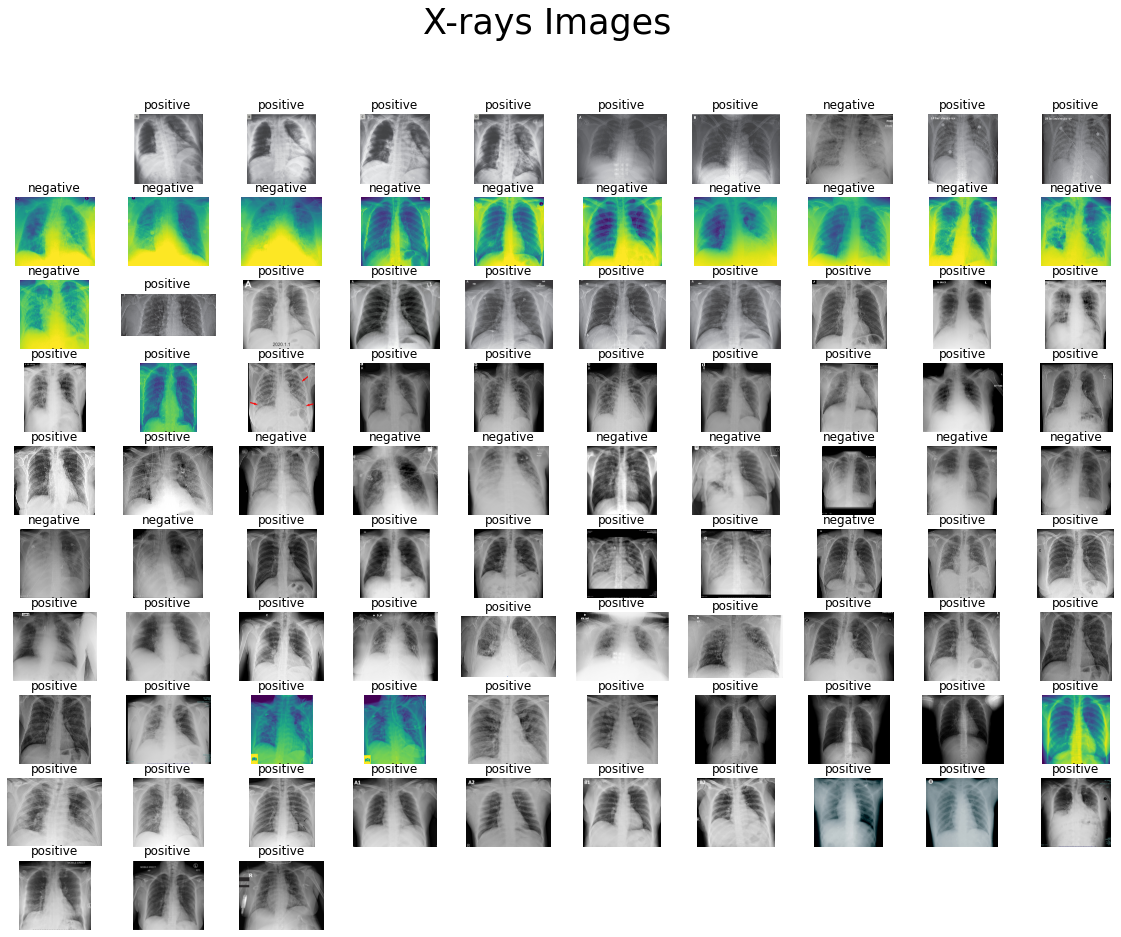

In [69]:
plot_xray_imgs(images, rows=10, title="X-rays Images")

In [70]:
labels

array(['positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'positive', 'positive', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positi

In [71]:
# one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [75]:
# set hyperparameters
BASE_LEARNING_RATE = 1e-3
EPOCHS = 15
BATCH_SIZE = 8

In [76]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =(None,None,3),
                                 include_top = False, weights = None)
mobnet_model = Sequential()
mobnet_model.add(base_mobilenet_model)
mobnet_model.add(GlobalAveragePooling2D())
mobnet_model.add(Dropout(0.5))
mobnet_model.add(Dense(69))
mobnet_model.add(Dropout(0.5))
mobnet_model.add(Dense(2, activation = 'sigmoid'))
mobnet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['accuracy'])
mobnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_None (Model)  (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 69)                70725     
_________________________________________________________________
dropout_8 (Dropout)          (None, 69)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 140       
Total params: 3,299,729
Trainable params: 3,277,841
Non-trainable params: 21,888
_______________________________________

In [77]:
mobnet_history = mobnet_model.fit_generator(trainAug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BATCH_SIZE,
    epochs=EPOCHS)

Epoch 1/15
9/9 [==============================] - 17s 2s/step - loss: 0.6683 - accuracy: 0.7308 - val_loss: 0.6919 - val_accuracy: 0.7368
Epoch 2/15
9/9 [==============================] - 9s 971ms/step - loss: 0.6864 - accuracy: 0.7292 - val_loss: 0.7242 - val_accuracy: 0.2632
Epoch 3/15
9/9 [==============================] - 7s 804ms/step - loss: 0.6563 - accuracy: 0.6724 - val_loss: 0.7794 - val_accuracy: 0.2632
Epoch 4/15
9/9 [==============================] - 8s 878ms/step - loss: 0.6109 - accuracy: 0.7000 - val_loss: 0.8199 - val_accuracy: 0.2632
Epoch 5/15
9/9 [==============================] - 8s 858ms/step - loss: 0.9600 - accuracy: 0.7769 - val_loss: 0.8485 - val_accuracy: 0.2632
Epoch 6/15
9/9 [==============================] - 8s 873ms/step - loss: 0.9658 - accuracy: 0.7154 - val_loss: 1.0943 - val_accuracy: 0.2632
Epoch 7/15
9/9 [==============================] - 9s 971ms/step - loss: 0.5893 - accuracy: 0.7500 - val_loss: 0.9209 - val_accuracy: 0.2632
Epoch 8/15
9/9 [======

In [78]:
mobnet_evaluation= mobnet_model.evaluate(trainX,trainY)
mobnet_evaluation

73/73 [==============================] - 3s 40ms/step


[1.02330968641255, 0.24657534062862396]

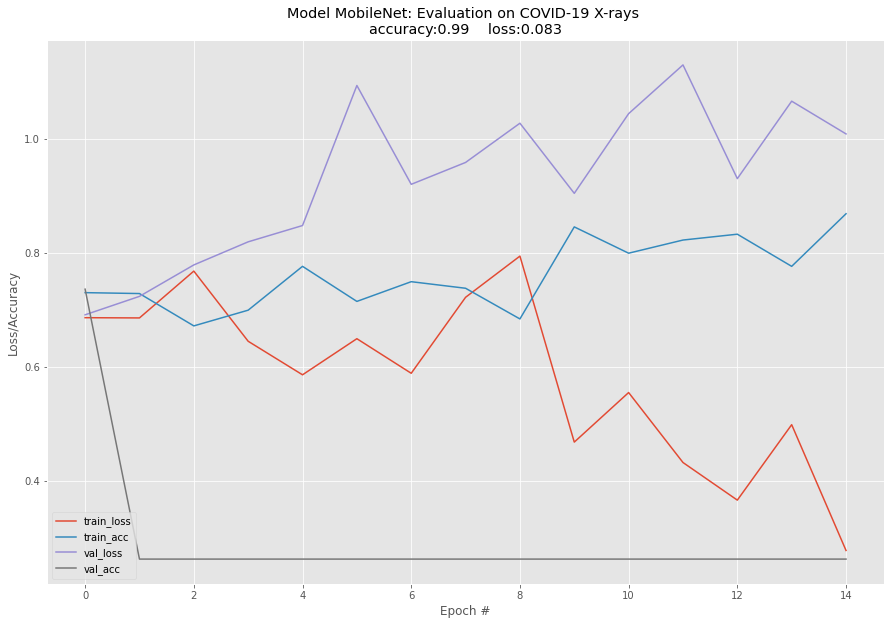

In [83]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(np.arange(0, N), mobnet_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), mobnet_history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), mobnet_history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), mobnet_history.history["val_accuracy"], label="val_acc")
plt.title("Model MobileNet: Evaluation on COVID-19 X-rays \naccuracy:{}    loss:{}".format("0.99",'0.083'))
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [87]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predict = mobnet_model.predict(testX, batch_size=BATCH_SIZE)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predict= np.argmax(predict, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1),predict, target_names=lb.classes_))


[INFO] evaluating network...
              precision    recall  f1-score   support

    negative       0.26      1.00      0.42         5
    positive       0.00      0.00      0.00        14

    accuracy                           0.26        19
   macro avg       0.13      0.50      0.21        19
weighted avg       0.07      0.26      0.11        19

